In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import cv2
import os

from scipy.spatial import distance
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import shuffle

from keras.models import Sequential
from keras.layers import Dense, Activation , Conv2D, MaxPool2D, Flatten
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input

import matplotlib.pyplot as plt
import seaborn as sns



In [3]:
# lấy data từ file

# dataset= {
#     'image_path': [],
#     'mask_status':[],
#     'where':[]
# }


# # dẫn đến link data lấy từng file
# for where in os.listdir(path):                                
#   for status in os.listdir(path+'/'+where):
#     for image in glob.glob(path+where+'/'+status+'/'+'*.png'):
#       dataset['image_path'].append(image)
#       dataset['mask_status'].append(status)
#       dataset['where'].append(where)

# dataset= pd.DataFrame(dataset)
# dataset.head()

# dataset['mask_status'][0]

# check số lượng ảnh của all dataset
# print('With Mask: ', dataset.value_counts('mask_status')[1])
# print('Without Mask: ', dataset.value_counts('mask_status')[0])

# # vẽ biểu đồ so sánh 
# sns.countplot(x=dataset['mask_status'])


# # chia data theo tên folder 
# train_df = dataset[dataset['where']== 'Train']
# test_df = dataset[dataset["where"] == "Test"]
# valid_df = dataset[dataset["where"] == "Validation"]

# #trước khi xáo trộn (shuffle)
# print(train_df.head(10))

# #shuffle xáo trộn dataset
# train_df= train_df.sample(frac=1)
# test_df= test_df.sample(frac=1)
# valid_df= valid_df.sample(frac=1)

# # sau khi shuffle
# print(train_df.head(10))



# # reset lại index .drop để bỏ cột index dc tạo ra khi reset (bỏ lun cột lv_0) 
# #ko có bước này sẽ ko chạy dòng for dc train_df
# train_df= train_df.reset_index().drop("index", axis=1)
# train_df.head()



# Encoding images 

# data=[]
# image_size= 150

# for i in range(len(train_df)):
#   #như trên chuuyển thành thanh màu xám
#   # image_path là  đường link dẫn đến ảnh
#   img_array = cv2.imread(train_df['image_path'][i], cv2.IMREAD_GRAYSCALE)

#   #resize the array
#   new_image_array = cv2.resize(img_array, (image_size,image_size))

#   #Encoding
#   if train_df['mask_status'][i] == 'WithMask':
#     data.append([new_image_array,1])
#   else:
#     data.append([new_image_array,0])

# data= np.array(data)
# data[0][0].shape 

# # shuffle data tăng độ chính xác
# np.random.shuffle(data)



In [4]:
mask_path= "/content/drive/My Drive/IT/dataset/Face Mask Dataset/Train/WithMask/"

no_mask_path= "/content/drive/My Drive/IT/dataset/Face Mask Dataset/Train/WithoutMask/"

In [5]:

img_mask= []
target_mask= []

img_no_mask= []
target_no_mask=[]

for i in os.listdir(mask_path):
  pic = os.path.join(mask_path, i)
  img_mask.append(pic)
  target_mask.append('mask')

for i in os.listdir(no_mask_path):
  pic = os.path.join(no_mask_path,i)
  img_no_mask.append(pic)
  target_no_mask.append('no_mask')

mask= pd.DataFrame()
mask['image']= img_mask
mask['target']=target_mask

no_mask= pd.DataFrame()
no_mask['image']= img_no_mask
no_mask['target']= target_no_mask

# nối 2 dataframe
data= pd.concat([mask,no_mask],axis=0, ignore_index= True)
data= shuffle(data)
data


,image,target
2279,/content/drive/My Drive/IT/dataset/Face Mask D...,mask
47,/content/drive/My Drive/IT/dataset/Face Mask D...,mask
6582,/content/drive/My Drive/IT/dataset/Face Mask D...,no_mask
6643,/content/drive/My Drive/IT/dataset/Face Mask D...,no_mask
1605,/content/drive/My Drive/IT/dataset/Face Mask D...,mask
...,...,...
3027,/content/drive/My Drive/IT/dataset/Face Mask D...,mask
6942,/content/drive/My Drive/IT/dataset/Face Mask D...,no_mask
4655,/content/drive/My Drive/IT/dataset/Face Mask D...,mask
5590,/content/drive/My Drive/IT/dataset/Face Mask D...,no_mask


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


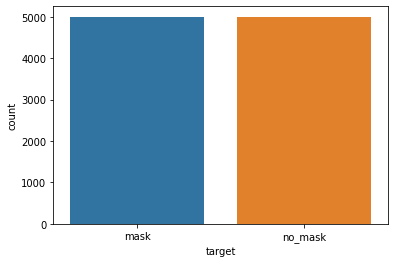

In [6]:
sns.countplot(data['target'])

In [7]:
# 10.000 row x 2 colum

train= data.iloc[0:8000, ]
val= data.iloc[8001:9000, ]
test= data.iloc[9001: , ]

print('Train: ' '\n', train['target'].value_counts(), '\n')
print('Val: ' '\n', val['target'].value_counts(), '\n')
print('Test: ' '\n', test['target'].value_counts(), '\n')


Train: 
 no_mask    4005
mask       3995
Name: target, dtype: int64 

Val: 
 mask       507
no_mask    492
Name: target, dtype: int64 

Test: 
 no_mask    502
mask       497
Name: target, dtype: int64 



In [8]:
#data augmentation

train_data= ImageDataGenerator(rescale=1./255, 
                               rotation_range=40,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               shear_range=0.2,
                               zoom_range=0.2,
                               horizontal_flip= True,
                               fill_mode= "nearest")

train_set = train_data.flow_from_dataframe(dataframe= train,
                                           x_col='image',
                                           y_col= 'target',
                                           target_size= (150,150),
                                           batch_size= 32,
                                           class_mode='binary')

val_data= ImageDataGenerator(rescale=1./255)
val_set = val_data.flow_from_dataframe(dataframe= val,
                                           x_col='image',
                                           y_col= 'target',
                                           target_size= (150,150),
                                           batch_size= 32,
                                           class_mode='binary')

test_data= ImageDataGenerator(rescale=1./255)
test_set = test_data.flow_from_dataframe(dataframe= val,
                                           x_col='image',
                                           y_col= 'target',
                                           target_size= (150,150),
                                           batch_size= 32,
                                           class_mode='binary')


Found 8000 validated image filenames belonging to 2 classes.
Found 999 validated image filenames belonging to 2 classes.
Found 999 validated image filenames belonging to 2 classes.


In [14]:
# model

vgg19= VGG19(weights='imagenet', include_top=False, input_shape=(128,128,3))

for layer in vgg19.layers:
  layer.trainable= False

model= Sequential()
model.add(vgg19)
model.add(Flatten())
model.add(Dense(1,activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.fit(train_set, validation_data= val_set, epochs= 5)

Epoch 1/5
250/250 [==============================] - 2537s 10s/step - loss: 0.3654 - accuracy: 0.8349 - val_loss: 0.0687 - val_accuracy: 0.9820
Epoch 2/5
250/250 [==============================] - 2476s 10s/step - loss: 0.1367 - accuracy: 0.9502 - val_loss: 0.0565 - val_accuracy: 0.9830
Epoch 3/5
250/250 [==============================] - 2470s 10s/step - loss: 0.1083 - accuracy: 0.9623 - val_loss: 0.0530 - val_accuracy: 0.9830
Epoch 4/5
250/250 [==============================] - 2481s 10s/step - loss: 0.0985 - accuracy: 0.9675 - val_loss: 0.0442 - val_accuracy: 0.9860
Epoch 5/5
250/250 [==============================] - 2482s 10s/step - loss: 0.0910 - accuracy: 0.9690 - val_loss: 0.0446 - val_accuracy: 0.9860


In [15]:
model.save('FaceMask.hdf5')

In [17]:
# .evaluate() -> [loss, accuracy]
test_loss, test_acc= model.evaluate(test_set,steps=5)

print('Test acc: ', round(test_acc,2))

5/5 [==============================] - 44s 9s/step - loss: 0.0570 - accuracy: 0.9812
Test acc:  0.98


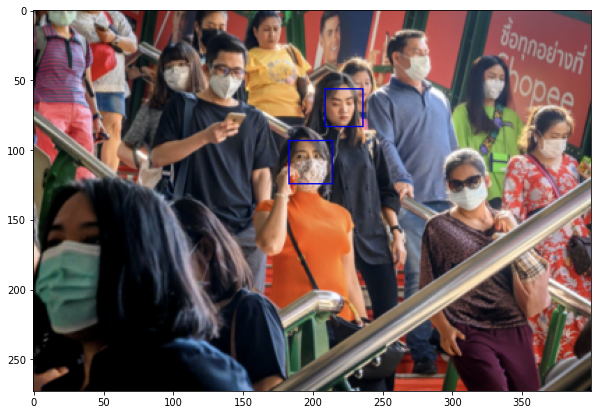

In [81]:
# haarcascades 

face_model = cv2.CascadeClassifier('/content/drive/My Drive/IT/dataset/haarcascade/haarcascade_frontalface_default.xml')
img= cv2.imread('/content/drive/My Drive/IT/dataset/face mask detection/images/maksssksksss61.png')

img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)

faces= face_model.detectMultiScale(img, scaleFactor=1.1, minNeighbors= 4)

out_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

for (x,y,w,h) in faces:
  cv2.rectangle(out_img, (x,y), (x+w, y+h), (0,0,224),1)

plt.figure(figsize=(10,10))
plt.imshow(out_img)

In [102]:
# 0 -> 0.5 : mask
# 0.5 -> 1 : no mask
from tensorflow.keras.models import load_model

mask_img= cv2.imread('/content/drive/My Drive/IT/dataset/face mask detection/images/maksssksksss61.png')

mask_img= cv2.resize(mask_img, (128,128))

mask_img= np.reshape(mask_img, [1,128,128,3])
mask_img= mask_img/255.0

model.predict(mask_img)


array([[0.00034863]], dtype=float32)

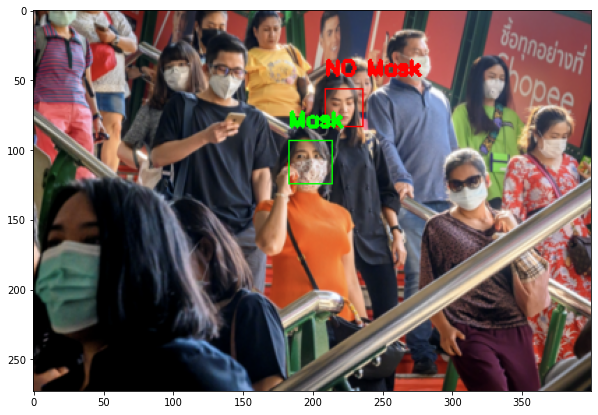

In [100]:
# paint 

mask_label= {0: 'Mask', 1:'NO Mask'}
dist_label={0:(0,255,0),1:(255,0,0)}
min_distance=0

if len(faces)>=1:
    label = [0 for i in range(len(faces))]
    for i in range(len(faces)-1):
        for j in range(i+1, len(faces)):
            dist = distance.euclidean(faces[i][:2],faces[j][:2])
            if dist< min_distance:
                label[i] = 1
                label[j] = 1
    new_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #colored output image

    for i in range(len(faces)):
        (x,y,w,h) = faces[i]

        crop = new_img[y:y+h,x:x+w]
        crop = cv2.resize(crop,(128,128))
        crop = np.reshape(crop,[1,128,128,3])/255.0
        mask_result = model.predict(crop)

        cv2.putText(new_img,mask_label[round(mask_result[0][0])],(x, y-10), cv2.FONT_HERSHEY_SIMPLEX,0.5,dist_label[round(mask_result[0][0])],2)
        cv2.rectangle(new_img,(x,y),(x+w,y+h),dist_label[round(mask_result[0][0])],1)

    plt.figure(figsize=(10,10))
    plt.imshow(new_img)
            
else:
    print("No Face!!")